# modifications:
1) weight initialization with RandomNormal: you can see it in the beginning of the definition of the functions "define_discriminator" and "define_generator" and within the generation of each layer: "kernel_initializer=init" instead of kernel_initializer="orthogonal".

2) add dropout after each layer.

3) add noise to labels. to do.

4) study best metrics for labels. to do.

5) reduce the number of needed attributes by doing operations on the latent space as described in the chapter 9 of the book.

6) look here: https://github.com/guyez/Conditional-Generation-of-Faces/blob/master/VAC%2BGAN.ipynb  they use this parameters:
    - discriminator_optimizer = Adam(lr=0.0002, beta_1=0)
    - classifier_optimizer = Adam(lr=0.0002, beta_1=0)
    - generator_optimizer = Adam(lr=0.00005, beta_1=0)
7) it's not ok to create labels with random values because there are attributes which can't be true together (for instance blond_hair and brown_hair).

# Note:
- this aux_gan has been obtained modifying the code of the cond_GAn given by Petru

- dropout(0.4) for the discriminator hidden layers gives error, use dropout(0.5).


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [226]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.initializers import RandomNormal
import random 

######################################## RANDOM SEED:
#random.seed(13)

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    



In [71]:
def get_attributes(filename, how_many, attributes_ind, dict_attributes, RandomListOfIntegers):
    # extract attribute names given the attribute indexes:
    list_attributes = []
    for attr in attributes_ind:
        list_attributes.append(dict_attributes[attr])
    # import the attributes you want:
    attributes = pd.read_csv(filename)[list_attributes]
    # convert to array
    attributes = np.array(attributes)
    # extract the attributes only of the number of images you want:
    attributes =  attributes[RandomListOfIntegers]
    
    return attributes

def load_images(dataset, images_directory, img_shape):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(images_directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2): # two calsses: 0 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, n_attr)) # HERE (n_samples, 40)
    return [z_input, labels]



# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples, n_attr, n_classes=2)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y


######### LOAD DATASET:
def load_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    RandomListOfIntegers = [random.randint(0,180000) for iter in range(how_many)] # 180000 is the training set size
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    dataset = [images, attributes]
    return dataset

######### LOAD FID DATASET:
def load_fid_dataset(how_many, ind_attributes, dict_attributes, images_directory = 'img_align_celeba_nozip', attr_file = 'list_attr_celeba.csv', img_shape = (178, 218, 3)):  
    # from 20k images I select "howmany" images for the fid. Note that "howmany" must be 10k
    RandomListOfIntegers = [random.randint(180000, 200000) for iter in range(how_many)]
    celeba_img = np.sort(os.listdir(images_directory))
    images_id = celeba_img[RandomListOfIntegers]
    images = load_images(images_id, images_directory, img_shape)
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    fid_dataset = [images, attributes]
    return fid_dataset

######### LOAD GROUN TRUTH LABELS FOR FID:
def load_groundtruth_labels(how_many, ind_attributes, dict_attributes, attr_file = 'list_attr_celeba.csv'):  
    # the 200000 could also be the exact number of images of celeba
    RandomListOfIntegers = [random.randint(0, 200000) for iter in range(how_many)]
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    return attributes

# plot of generated images
def plot_images(examples, n_test_images):
    # plot images
    for i in range(n_test_images):
        # define subplot
        plt.subplot(n_test_images/4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [227]:
# define the standalone discriminator model
# A best practice involves using an embedding
# layer followed by a fully connected layer with a linear activation that scales the embedding to
# the size of the image before concatenating it in the model as an additional channel or feature
# map. A version of this recommendation was described in the 2015 paper titled Deep Generative
# Image Models using a Laplacian Pyramid of Adversarial Networks.
    
def define_discriminator(n_attr,in_shape=(64,64,3)): # HERE
    
    # kernel initializer:
    init = RandomNormal(stddev=0.02)
    
    # input layer:
    in_image = Input(shape=in_shape)

    # downsample to 32x32
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(in_image) ##in_image
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 16x16
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 8x8
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample to 4x4
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # downsample 2x2
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same',kernel_initializer=init, spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # dropout
    fe = Dropout(0.4)(fe)
    
    # output about fake/real image:
    out1 = Dense(1, activation='sigmoid')(fe)
    # output about attributes:
    out2 = Dense(n_attr, activation="sigmoid")(fe) ##
    
    # define model
    model = Model([in_image], [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator_old(latent_dim, n_attr, embedding_dim):
    # weights initialization:
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(n_attr,))
    # embedding for categorical input
    #li = Embedding(n_attr, embedding_dim)(in_label)
    # linear multiplication
    n_nodes = 4 * 4 * 3
    li = Dense(n_nodes)(in_label)
    # reshape to additional channel
    li = Reshape((4, 4, n_attr))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 128 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, kernel_size=4, activation='tanh', padding='same', kernel_initializer=init)(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "binary_crossentropy"], optimizer=opt) ##
    return model

In [228]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images):
    bat_per_epo = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
            # update discriminator model weights
            d_metrics1 = d_model.train_on_batch(X_real, [y_real, labels_real])##
            #d_loss1, _ = d_model.train_on_batch([X_real,labels_real], y_real)##
            # use this command: d_model.metrics_names to see what returns "d_model.train_on_batch"
            d_loss1 = d_metrics1[0]
            # generate ✬fake✬ examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_metrics2 = d_model.train_on_batch(X_fake, [y_fake, labels])
            d_loss2 = d_metrics2[0]
            # prepare points in latent space as input for the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, batch_size, n_attr, n_classes=2)
            # create inverted labels for the fake samples
            y_gan = np.ones((batch_size, 1))
            # update the generator via the discriminator✬s error
            #_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            g_metrics = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            g_loss = g_metrics[0]
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        g_model.save('cgan/cgan_generator' +str(i+j)+'.h5')
        model = load_model('cgan/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
        
        z_input, labels = generate_latent_points(latent_dim, n_test_images, n_attr, n_classes=2 )
        # create laels with random values:
        labels = np.zeros((n_test_images, n_attr)) # HERE (100, 40)
        # convert to "1" the attributes you want to test for conditioning:
        ind_test_attribtes = ind_test_attributes > 0
        labels[:, ind_test_attributes] = 1
        #labels[:,0] = 1
        # generate images
        X = g_model.predict([z_input, labels])
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        plot_images(X, n_test_images)
        
        

In [229]:
######### ATTRIBUTE SELECTION:

# list the indexes of the attributes to be used to condition the generator:
dict_attributes = {1: '5_o_Clock_Shadow', 2: 'Arched_Eyebrows', 3: 'Attractive', 4: 'Bags_Under_Eyes', 
                   5: 'Bald', 6: 'Bangs', 7: 'Big_Lips', 8: 'Big_Nose', 9: 'Black_Hair', 10: 'Blond_Hair', 
                   11: 'Blurry', 12: 'Brown_Hair', 13: 'Bushy_Eyebrows', 14: 'Chubby', 15: 'Double_Chin', 
                   16: 'Eyeglasses', 17: 'Goatee', 18: 'Gray_Hair', 19: 'Heavy_Makeup', 20: 'High_Cheekbones', 
                   21: 'Male', 22: 'Mouth_Slightly_Open', 23: 'Mustache', 24: 'Narrow_Eyes', 25: 'No_Beard', 
                   26: 'Oval_Face', 27: 'Pale_Skin', 28: 'Pointy_Nose', 29: 'Receding_Hairline', 30: 'Rosy_Cheeks', 
                   31: 'Sideburns', 32: 'Smiling', 33: 'Straight_Hair', 34: 'Wavy_Hair', 35: 'Wearing_Earrings', 
                   36: 'Wearing_Hat', 37: 'Wearing_Lipstick', 38: 'Wearing_Necklace', 39: 'Wearing_Necktie', 40: 'Young'}

ind_attributes = [9, 10, 32] # Black_Hair, Blond_Hair, Smiling, Eyeglasses
'''
ind_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40 ]'''
# use booleans to indicate respectively wrt the "ind_attributes" which attributes must be used to test the conditioning:
ind_test_attributes = np.array([1, 1, 1])
'''ind_test_attributes = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1 , 1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1])'''

'ind_test_attributes = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1 , 1,\n                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,\n                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1,\n                               1, 1, 1, 1, 1, 1, 1, 1, 1 ,1])'

>1, 6/6, d1=0.934, d2=1.399 g=1.371


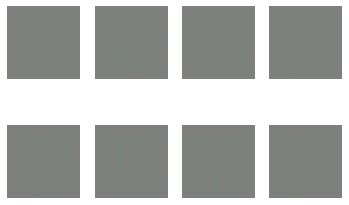

>2, 6/6, d1=0.591, d2=1.531 g=1.381


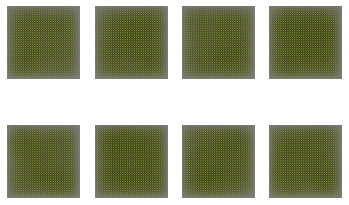

>3, 6/6, d1=0.709, d2=1.321 g=1.525


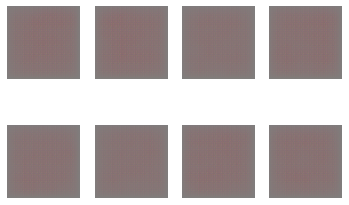

>4, 6/6, d1=0.919, d2=1.671 g=1.330


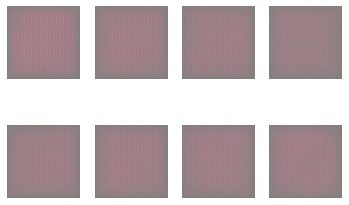

>5, 6/6, d1=0.943, d2=1.291 g=1.588


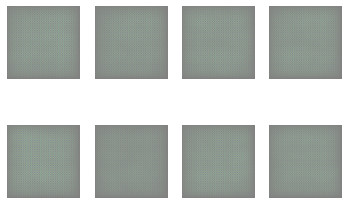

>6, 6/6, d1=0.767, d2=1.319 g=1.458


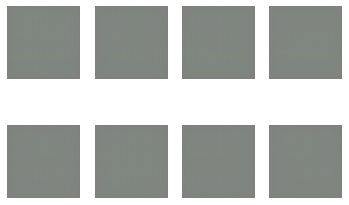

KeyboardInterrupt: 

In [230]:
############### PARAMETERS:

how_many = 200 ############################ number of images to use for training

# size of the latent space
latent_dim = 100

#dimension of the embedding layer in the generator:
embedding_dim = 50 # the book uses 50

# divide dataset into this number of batches:
batch_size = 32 # number of images per batch

n_epochs = 100

n_test_images = 8 # number of images to save per each epoch, USE MULTIPLE OF 4


###########à FIXED PARAM: DON'T TOUCH THEM
# number of attributes per image:
n_attr = len(ind_attributes) 
n_classes=2 # just 2 possible value for each attribute

################# MODELS:
# create the discriminator
d_model = define_discriminator(n_attr)
#d_model.summary()

# create the generator
g_model = define_generator_old(latent_dim, n_attr, embedding_dim)
#g_model.summary()

# create the gan
gan_model = define_gan(g_model, d_model)

dataset = load_dataset(how_many, ind_attributes, dict_attributes)

In [ ]:
###################################### TRAINING
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, n_test_images);

In [ ]:
######### LOAD GROUN TRUTH LABELS FOR FID:
def load_groundtruth_labels(how_many, ind_attributes, dict_attributes, attr_file = 'list_attr_celeba.csv'):  
    # the 200000 could also be the exact number of images of celeba
    RandomListOfIntegers = [random.randint(0, 200000) for iter in range(how_many)]
    attributes = get_attributes(attr_file, how_many, ind_attributes, dict_attributes, RandomListOfIntegers)
    attributes[attributes<=0] = 0
    return attributes


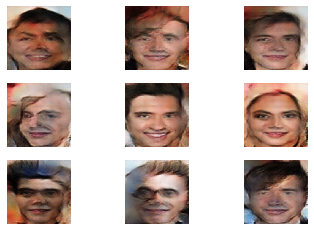

In [22]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

model = load_model('cgan/model_3attr_50k_25epoche_sembra_condizionare_bene.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
# specify labels
labels = np.zeros((latent_dim, n_attr))
#labels = load_groundtruth_labels(100, ind_attributes, dict_attributes)
labels[:, 2] = 1
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 3)

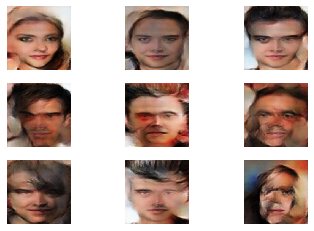

In [27]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

model = load_model('cgan/model_3attr_50k_25epoche_sembra_condizionare_bene.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
latent_points, labels = generate_latent_points(latent_dim, 100, n_attr)
# specify labels
labels = np.zeros((latent_dim, n_attr))
#labels = load_groundtruth_labels(100, ind_attributes, dict_attributes)
labels[:, 1] = 0
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 3)